# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Знакомство с данными

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
((data.isna().sum())/len(data))*100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

### Работа с пропусками и дубликатами

In [7]:
data.duplicated().sum()

4

In [8]:
data = data.drop_duplicates()

In [9]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

**Удалим ненужные столбцы**

In [10]:
columns_to_drop = ['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen']

In [11]:
data = data.drop(columns_to_drop, axis=1)

In [12]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [13]:
data.shape

(354365, 10)

**Заполнение пропусков в стобце VehicleType**

In [14]:
data['VehicleType'] = data['VehicleType'].fillna('other')

**Заполнение пропусков в столбце Repaired. При отсутствии значения можно предположить, что машина не была в ремонте**

In [15]:
data['Repaired'] = data['Repaired'].fillna('no')

**В столбце FuelType значения petrol (американский) и gasoline (английский) означают одно и тоже - бензин. Осуществим замену на gasoline**

**Похожая ситуация с lpg и cng, это системы работы на газу. Переименуем их на gas**

**Значения nan заменим на other**

In [16]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [17]:
data = data.replace(to_replace='petrol', value='gasoline')

In [18]:
data = data.replace(to_replace=['lpg','cng'], value='gas')

In [19]:
data['FuelType'] = data['FuelType'].fillna('other')

In [20]:
data['FuelType'].unique()

array(['gasoline', 'other', 'gas', 'hybrid', 'electric'], dtype=object)

In [21]:
data.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType                0
Brand                   0
Repaired                0
dtype: int64

**Проруски в Model заменим на other**

In [22]:
data['Model'] = data['Model'].fillna('other')

In [23]:
data.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox             19833
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
Repaired                0
dtype: int64

**Пропуски в Gearbox**

Кроме АКПП и МКПП существуют РКПП и ВКПП. Пропуски заполним значением other.

In [24]:
data['Gearbox'] = data['Gearbox'].fillna('other')

In [25]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

### Работа с выбросам

In [26]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


**Вывод: наблюдаются выбросы в слобцах Price,RegistrationYear,Power**

**Рассмотрим столбец Price**

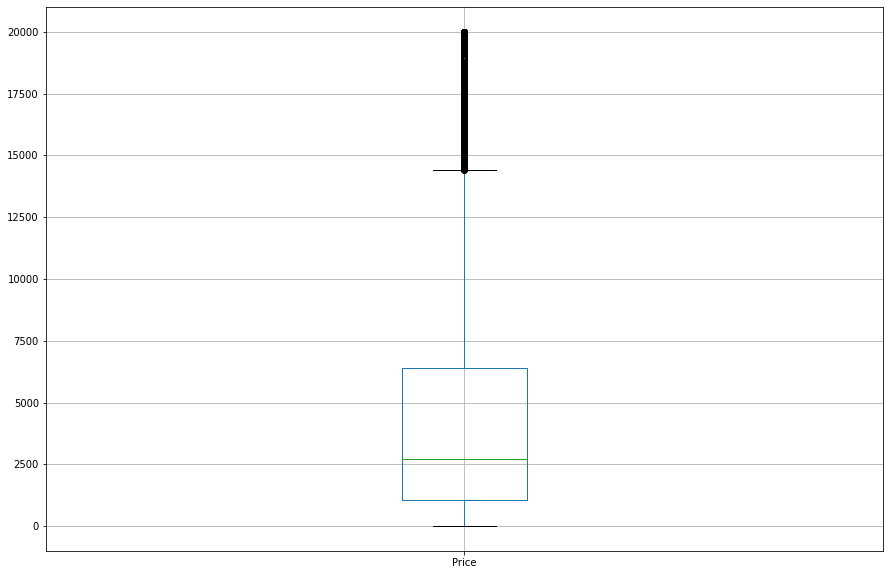

In [27]:
data.boxplot(column='Price',figsize=(15,10));

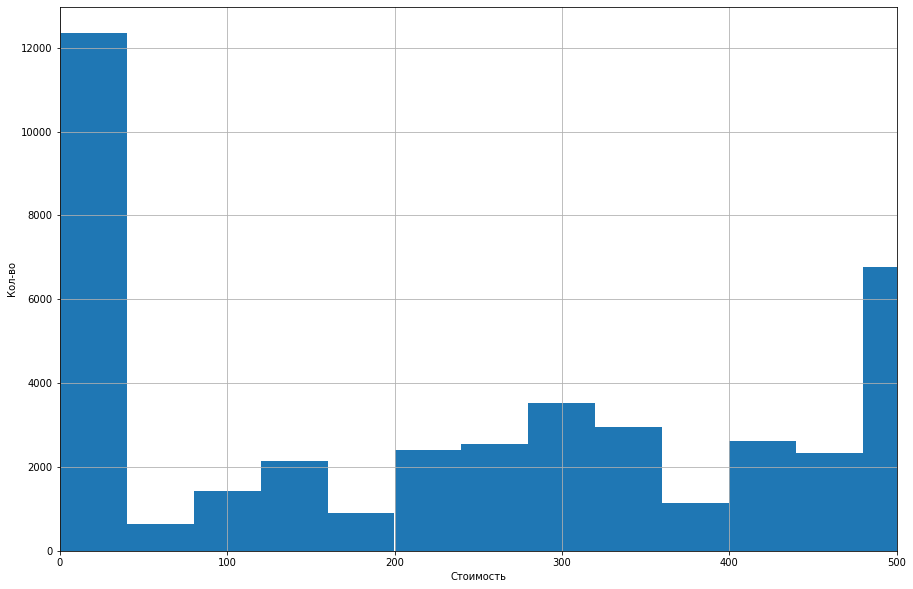

In [28]:
data['Price'].hist(bins=500,figsize=(15,10))
plt.xlabel('Стоимость')
plt.ylabel('Кол-во')
plt.xlim(0,500);

In [29]:
round((len(data[data['Price']<=120])/len(data))*100,2)

4.14

Выбросим из сета данных все значения цены меньше 120 евро. С большой вероятностью эти машины годятся только на металлолом. Их общее количество из дата сета составляет 4.14%

In [30]:
data = data.query('Price > 120')

**Рассмотрим столбец RegistrationYear**

In [31]:
sorted(data['RegistrationYear'].unique())

[1000,
 1001,
 1039,
 1111,
 1234,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 7000,
 7100,
 7800,
 8200,
 8500,
 8888,
 9000,
 9450,
 9999]

Оставим машины с датой регистрации в диапозоне 50 лет, с 1969 по 2019

In [32]:
data = data[(data['RegistrationYear'] >= 1969)|(data['RegistrationYear'] <= 2016)]

**Рассмотрим столбец Power**

(0.0, 800.0)

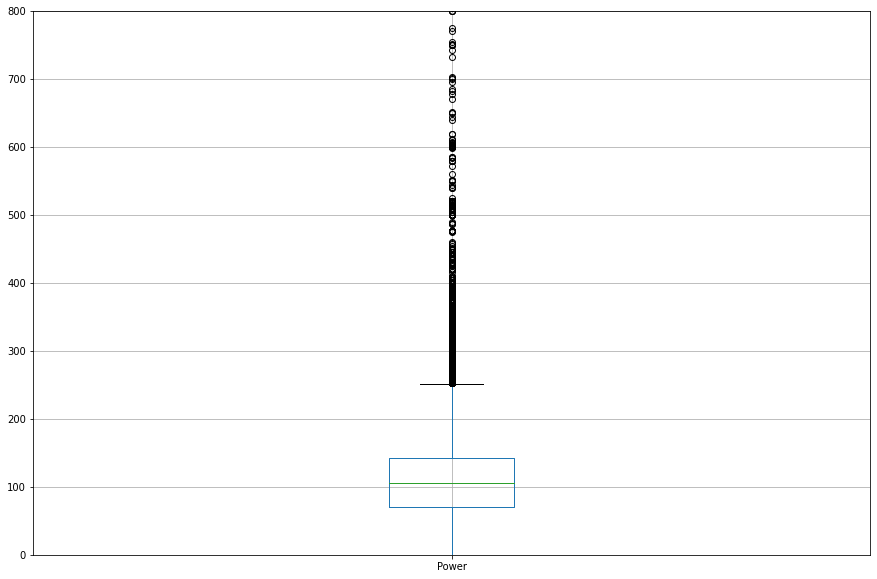

In [33]:
data.boxplot(column='Power',figsize=(15,10));
plt.ylim(0,800)

In [34]:
data.shape

(339708, 10)

Значения в столбце Power, что ниже 60 л.с., заменим на медианные значения мощности уникальных моделей.

In [35]:
for row in data['Model'].unique():
    data.loc[(data['Power'] < 60), 'Power'] = data.loc[(data['Model']== row), 'Power'].median()

Значения в столбце Power, что выше 800 л.с., заменим на медианные значения мощности уникальных моделей.

In [36]:
for row in data['Model'].unique():
    data.loc[(data['Power'] > 800), 'Power'] = data.loc[(data['Model']== row), 'Power'].median()

In [37]:
data['Power'].describe()

count    339708.000000
mean        121.626933
std          48.727474
min          60.000000
25%          95.000000
50%         105.000000
75%         143.000000
max         800.000000
Name: Power, dtype: float64

(0.0, 810.0)

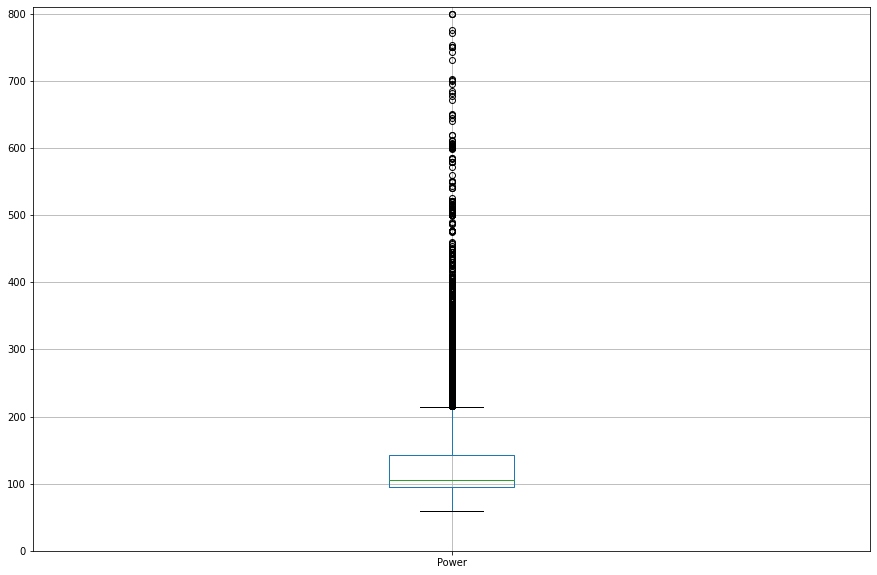

In [38]:
data.boxplot(column='Power',figsize=(15,10));
plt.ylim(0,810)

## Обучение моделей

### Подготовка выборок под обучение

In [39]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,other,1993,manual,100.0,golf,150000,gasoline,volkswagen,no
1,18300,coupe,2011,manual,190.0,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75.0,golf,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no


In [40]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

**Разбивка данных на тренировочную и валидационную**

In [41]:
data_train, data_sep = train_test_split(data,train_size=0.6, test_size=0.4, random_state=12345)

In [42]:
data_valid, data_test = train_test_split(data_sep, test_size=0.5, random_state=12345)

**Проверка соотношения разбивки данных**

In [43]:
round((len(data_train)/len(data)*100),2)

60.0

In [44]:
round((len(data_valid)/len(data)*100),2)

20.0

In [45]:
round((len(data_test)/len(data)*100),2)

20.0

**Выделение целевого признака**

Тренировочные данные

In [46]:
features_train = data_train.drop('Price',axis=1)
target_train = data_train['Price']

Валидационные данные

In [47]:
features_valid = data_valid.drop('Price',axis=1)
target_valid = data_valid['Price']

Тренировочные данные

In [48]:
features_test = data_test.drop('Price',axis=1)
target_test = data_test['Price']

**Проведем кодирование категориальных признаков**

In [51]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']
encoder.fit(features_train[cat_columns])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)

In [52]:
features_train[cat_columns] = encoder.transform(features_train[cat_columns])
features_valid[cat_columns] = encoder.transform(features_valid[cat_columns])
features_test[cat_columns] = encoder.transform(features_test[cat_columns])

**Проведем масштабиование количественных признаков**

In [53]:
to_scale = ['RegistrationYear','Power','Kilometer']

In [54]:
scaler = StandardScaler()
scaler.fit(features_train[to_scale])

StandardScaler()

In [55]:
features_train[to_scale] = scaler.transform(features_train[to_scale])
features_valid[to_scale] = scaler.transform(features_valid[to_scale])
features_test[to_scale] = scaler.transform(features_test[to_scale])

In [56]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
214859,4.0,-0.055852,1.0,2.940996,28.0,0.576919,2.0,1.0,0.0
10245,3.0,0.181119,1.0,0.992185,95.0,0.576919,2.0,20.0,0.0
137095,5.0,-0.041912,1.0,-0.956626,83.0,0.576919,2.0,24.0,0.0
329044,4.0,0.083543,1.0,0.992185,116.0,0.576919,2.0,38.0,0.0
223073,4.0,-0.014033,1.0,0.581909,28.0,0.576919,2.0,1.0,0.0


In [57]:
features_valid.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
103453,1.0,0.013845,0.0,2.243527,11.0,0.576919,2.0,2.0,0.0
75599,7.0,0.111422,0.0,0.376771,116.0,-1.577090,2.0,38.0,0.0
7926,4.0,0.083543,1.0,0.787047,140.0,-1.577090,2.0,30.0,0.0
259766,5.0,-0.069791,1.0,-0.443781,199.0,-1.038588,2.0,9.0,1.0
30543,3.0,0.181119,1.0,-0.730974,116.0,-2.384844,4.0,38.0,0.0


In [58]:
features_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
325761,3.0,-0.055852,2.0,-0.443781,232.0,0.576919,4.0,24.0,0.0
29773,5.0,0.027785,1.0,-0.341212,28.0,-0.769337,2.0,1.0,0.0
270330,0.0,-0.014033,1.0,-0.443781,202.0,0.576919,4.0,38.0,0.0
97814,5.0,-0.041912,1.0,-0.956626,173.0,0.576919,2.0,38.0,0.0
232041,6.0,0.027785,0.0,1.320406,242.0,0.576919,2.0,39.0,0.0


### Подбор гиперпараметров

In [59]:
RANDOM=12345

**CatBoost**

In [60]:
# cat = CatBoostRegressor(loss_function='RMSE',random_seed=RANDOM,silent=True)

In [61]:
params = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'iterations': range(10, 100, 10),
    'depth': range(4,10,2)
}

In [62]:
# grid_cat = GridSearchCV(cat,params,cv=3,scoring='neg_mean_squared_error')
# grid_cat.fit(features_train, target_train);
# grid_cat.best_params_

In [63]:
cat = CatBoostRegressor(loss_function='RMSE',random_seed=RANDOM,silent=True,depth=8,iterations=90,learning_rate=0.5)
cat.fit(features_train, target_train)
pred = cat.predict(features_valid)
print('RMSE: ',round(mean_squared_error(target_valid, pred) ** .5))

RMSE:  1727


**Вывод:** получили для CatBoost лучшие параметры и рассмотрели предварительную оценку RMSE

**LightGBM**

In [64]:
# gbm = LGBMRegressor(seed=RANDOM)

In [65]:
params = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'max_depth': range(4,10,2),
    'n_estimators': range(1,100,20)
}

In [66]:
# grid_gbm = GridSearchCV(gbm, params, cv=3, scoring='neg_mean_squared_error')
# grid_gbm.fit(features_train, target_train);
# grid_gbm.best_params_

In [67]:
gbm = LGBMRegressor(learning_rate=0.4,max_depth=8,n_estimators=81,seed=RANDOM)
gbm.fit(features_train, target_train)
pred = gbm.predict(features_valid)
print('RMSE: ',round(mean_squared_error(target_valid, pred) ** .5))

RMSE:  1727


**Вывод:** получили для LGBMRegressor лучшие параметры и рассмотрели предварительную оценку RMSE

**RandomForestRegressor**

In [68]:
# model_rfr = RandomForestRegressor(random_state=RANDOM)

In [69]:
params = {
    'max_depth':range(1,23,3),
    'n_estimators': range(1,100,10),
}

In [70]:
# grid_rfr = GridSearchCV(model_rfr,params,cv=3,scoring='neg_mean_squared_error')
# grid_rfr.fit(features_train, target_train)
# grid_rfr.best_params_

In [71]:
model_rfr = RandomForestRegressor(max_depth=19,n_estimators=91,random_state=RANDOM)
model_rfr.fit(features_train, target_train)
pred = model_rfr.predict(features_valid)
print('RMSE: ',round(mean_squared_error(target_valid, pred) ** .5))

RMSE:  1681


**Вывод:** получили для RandomForestRegressor лучшие параметры и рассмотрели предварительную оценку RMSE

## Анализ моделей

### Рассмотрим показатели RMSE каждой модели на тестовой выборке и время их работы

In [72]:
def analysis(model):
    sf = time.time()
    model = model
    model.fit(features_train, target_train)
    ef = time.time()
    fit_time = round(ef-sf,2)
    
    sp = time.time()
    prediction = model.predict(features_valid)
    ep = time.time()
    pred_time = round(ep-sp,2)
    
    rmse = round(mean_squared_error(target_valid, prediction) ** .5)
    
    return fit_time,pred_time,rmse

In [73]:
models = [analysis(cat),analysis(gbm),analysis(model_rfr)]

In [74]:
pd.DataFrame(list(models),
            columns=['fit_time_sec','pred_time_sec','RMSE'],
            index=['CatBoost','LightGBM','RandomFR'])

,fit_time_sec,pred_time_sec,RMSE
CatBoost,3.82,0.03,1727
LightGBM,244.89,0.40,1727
RandomFR,34.66,1.51,1681


### Вывод

**Среди используемых моделей лучший показатель RMSE у RandomForestRegressor, в то время как CatBoost показал себя самым быстрым.**

**Опираясь на полученные данные считаю CatBoost наиболее привлекательной моделью и по показателям и по времени, так как RMSE от RandomForestRegressor несильно отличается**

## Тестирование лучшей модели

**Рекомендую использовать CatBoost, так как обладает самой высокой скоростью обучения,предсказания и RMSE слабо отличается от лучшего показателя.**

In [75]:
start=time.time()
cat = CatBoostRegressor(loss_function='RMSE',random_seed=RANDOM,silent=True,depth=8,iterations=90,learning_rate=0.5)
cat.fit(features_train, target_train)
end=time.time()
fit_time = round(end-start,2)

start=time.time()
pred = cat.predict(features_test)
end=time.time()
pred_time = round(end-start,2)
print('Время обучения(сек): ',fit_time)
print('Время предсказания(сек): ',pred_time)
print('RMSE: ',round(mean_squared_error(target_test, pred) ** .5))

Время обучения(сек):  3.57
Время предсказания(сек):  0.01
RMSE:  1712
